# map2model v0.0.9
## Takes GML file produced by topology code, combines with geology polygons, structure points and dtm to create 3D model in gempy.<br><br>

Limitations: no faults yet, no plutons yet, no dykes, no sills. Faults and plutons will come soon, sills require us to assign a unique surface to each instance of a sill (sill between units A and B needs to be different from sill of same age and strat codes as one found between E and F). Dykes via cokriging are really hard without just cookie cutting them in (but that is not our problem!). We are not checking for onlap relationships, which can perhaps been seen by having lots of units from one series adjacent to the youngest surface of the older series. Could also think about interpreting these as faults to introduce conceptual uncertainty. All mistakes belong to Mark Jessell, topology code that feeds this system by Vitaliy Ogarko.<br><br>

Geology layer needs to have some unique strat code or text, some group code or text<br>
Structure layer needs dip/dip direction<br>

<font color='red'>Currently hardwired to GSWA 500K map so needs work...</font>


In [1]:
import matplotlib
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlopen
import numpy as np
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt
import os
import rasterio
from rasterio.transform import from_origin
from rasterio import features
%matplotlib inline
import sys, os
sys.path.insert(0,"../..")
print(os.getcwd())
rootdir=r'/home/lgrose/Repositories/map2model/'
os.chdir(rootdir)
print(os.getcwd())

/mnt/c/Users/lgrose/Documents/Repositories/map2model
/mnt/c/Users/lgrose/Documents/Repositories/map2model


## First we test to see if we have access to the online data we need
mj: We actually only need to check for the Hawiian data at the moment, but soon this will be important for other online data sources.

In [2]:
from PIL import Image
try:
    import httplib
except:
    import http.client as httplib

def have_access(url):
    conn = httplib.HTTPConnection(url, timeout=5)
    try:
        conn.request("HEAD", "/")
        conn.close()
        display(Image.open("./graphics/yes.png"))
        print("available: "+url)
    except:
        conn.close()
        display(Image.open("./graphics/no.png"))
        print("NOT available: "+url)

#have_access("services.slip.wa.gov.au")
have_access("oos.soest.hawaii.edu")
#have_access("130.95.198.59")



available: oos.soest.hawaii.edu


## Next we define an area of interest and some other basic stuff

In [3]:
mname='hams2' #root name of model input data

print(os.getcwd())
newdir=rootdir+mname
print(newdir)
os.chdir(newdir)

if not os.path.exists(os.path.isdir('tmp')): 
    os.mkdir('tmp')
    os.mkdir('gempy')
    os.mkdir('dtm')

text=False    #display debug text
graphics=True #display debug images


model_base=-8200 # top could be found using highest point in topo data

minlong=117
maxlong=118
minlat=-23
maxlat=-22

minx=500057    #left hams
maxx=603028    #right
miny=7455348   #bottom
maxy=7567953   #top
    

step_out=0.045 #add (in degrees) so edge pixel from dtm reprojection are not found

src_crs = 'epsg:2346'  #input data coord ref system (assumed to be geodetic lat/long WGS84)
dst_crs = 'epsg:28350' #model ref system (assumed to be something with metre coordinates)

# 'epsg:28350'  =  GDA_1994_MGA_Zone_50 
# 'epsg:4326'   =   wgs84 GEODETIC LAT/LONG 

orientation_decimate=0   # decimation of orientaiton data (0 = no decimation)
contact_decimate=30   # decimation of contact data (0 = no decimation)

gcode='SUPERGROUP'
dcode='DIP'
ddcode='DIP_DIR'
ccode='CODE'


/mnt/c/Users/lgrose/Documents/Repositories/map2model
/home/lgrose/Repositories/map2model/hams2


## Download and reproject the appropriate SRTM data
mj: Getting this from Hawaii, but could also get from Geoscience Australia (expect when I tried via WCS it blew up for more than 0.25 degree square areas, but I am pretty sure this is a OWS python plugin problem not GA since I can load the whole data with QGIS)

In [4]:
import geopandas as gpd
from shapely.geometry.polygon import Polygon
from shapely.geometry import Point

bottom=minlat-step_out
top=maxlat+step_out
left=minlong-step_out
right=maxlong+step_out

122 122
http://oos.soest.hawaii.edu/thredds/dodsC/srtm30plus_v11_land.ascii?elev[8039:1:8160][35639:1:35760]
max height = 1113
rounded up max height = 1200
{'type': 'Polygon', 'coordinates': [[[500000.0, 7567173.04248], [500000.0, 7454635.24385], [604180.573815, 7454273.81794], [604945.176621, 7566824.227421], [500000.0, 7567173.04248]]]}


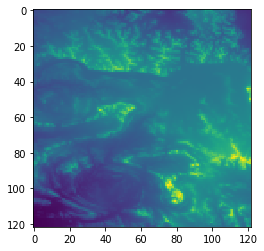

In [5]:
minxll=int(((minlong+180)*120)-step_out)
maxxll=int(((maxlong+180)*120)+step_out)
minyll=int(((minlat+90)*120)-step_out)
maxyll=int(((maxlat+90)*120)+step_out)

sizex=round(maxxll-minxll+1)
sizey=round(maxyll-minyll+1)
print(sizex,sizey)
minxll=str(minxll)
maxxll=str(maxxll)
minyll=str(minyll)
maxyll=str(maxyll)
bbox="["+minyll+":1:"+maxyll+"]["+minxll+":1:"+maxxll+"]"
print
link = "http://oos.soest.hawaii.edu/thredds/dodsC/srtm30plus_v11_land.ascii?elev"+bbox

print (link)
f = urlopen(link)
myfile = f.read()
myfile2=myfile.decode("utf-8") 
data=myfile2.split("---------------------------------------------")
import re

grid=re.sub('\[.*\]','',data[1]).replace(",","").replace("elev.elev","").replace("\n"," ").replace("  "," ")
#print(grid)
grid=grid.split(" ")
grid=grid[2:(sizex*sizey)+2]
OPeNDAP = np.ones((sizey,sizex), dtype='int16')
k=0
for j in range (0, sizey, 1):
    for i in range (0, sizex, 1):
        OPeNDAP[sizey-1-j][i]=int(float(grid[k]))
        k+=1

maxtopo=np.amax(OPeNDAP)
print("max height =",maxtopo)
maxtopo=np.around(maxtopo,-2)+100
print("rounded up max height =",maxtopo)


if(graphics):
    plt.imshow(OPeNDAP)
if(text):
    print(myfile)


transform = from_origin(minlong, maxlat,0.008333333,0.008333333)

new_dataset = rasterio.open('./dtm/'+mname+'_dtm.tif', 'w', driver='GTiff',
                            height = OPeNDAP.shape[0], width = OPeNDAP.shape[1],
                            count=1, dtype=str(OPeNDAP.dtype),
                            crs='+proj=longlat',
                            transform=transform)

new_dataset.write(OPeNDAP, 1)
new_dataset.close()

import numpy as np
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling



with rasterio.open('./dtm/'+mname+'_dtm.tif') as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rasterio.open('./dtm/'+mname+'_dtm_rp.tif', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)
            
with rasterio.open('./dtm/'+mname+'_dtm.tif') as dataset:

    # Read the dataset's valid data mask as a ndarray.
    mask = dataset.dataset_mask()
    for geom, val in rasterio.features.shapes(
                mask, transform=dataset.transform):

            # Transform shapes from the dataset's own coordinate
            # reference system to 28350.
            geom_rp = rasterio.warp.transform_geom(
                dataset.crs, dst_crs, geom, precision=6)

            # Print GeoJSON shapes to stdout.
            print(geom_rp)
            

## Load stratigraphy graph and create list of series (aka groups)
mj: The choice of what constitutes basic unit and what a group of units is hard-wired at the moment, but could be altered to any pair. Not even sure we need two levels but it seemed like a good idea at the time. Note that this needs the arcgis plugin version of the topology code (for now) as it seperates the different sub graphs. Text outputs list alternate topologies for series and surfaces, which if confirmed by comapring max-min ages will be a nice source of uncertainty.

In [6]:
G=nx.read_gml('./graph/'+mname+'_strat.gml',label='id') # load a stratigraphy with groups needs to feed via yed!!
#print(nx.info(G, n=None))

glabels = {}
groups=0
nlist=list(G.nodes)
for n in nlist: # Find out total number of groups and their names groups
    if('isGroup' in G.nodes[n]):
        groups+=1
        glabels[n]=G.nodes[n]['LabelGraphics']['text'].replace(" ","_")
        print(G.nodes[n]['LabelGraphics']['text'].replace(" ","_"))
        
print(glabels)

Hamersley_Group
Fortescue_Group
A-b-PRK
A-s-PRK
Turee_Creek_Group
Shingle_Creek_Group
A-s-PMI
Wyloo_Group
{0: 'Hamersley_Group', 2: 'Fortescue_Group', 19: 'A-b-PRK', 28: 'A-s-PRK', 13: 'Turee_Creek_Group', 30: 'Shingle_Creek_Group', 26: 'A-s-PMI', 32: 'Wyloo_Group'}


groups: 8

0 Hamersley_Group ----------------------


/home/lgrose/FME/fme/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/lgrose/FME/fme/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


choices: 1
15 P_-HAo-ci
17 P_-HAw-fr
16 P_-HAj-xci-od
5 P_-HAb-cib
4 A-HAS-xsl-ci
11 A-HAd-kd
1 A-HAm-cib

2 Fortescue_Group ----------------------
choices: 1
12 A-FOj-xs-b
22 A-FOu-bbo
3 A-FOp-bs
9 A-FOo-bbo
8 A-FOh-xs-f
21 A-FOr-b

19 A-b-PRK ----------------------
choices: 1
20 A-b-PRK

28 A-s-PRK ----------------------
choices: 1
29 A-s-PRK

13 Turee_Creek_Group ----------------------
choices: 4
23 P_-TK-s
14 P_-TKa-xs-k
36 P_-TKo-stq
37 P_-TKk-sf
....
14 P_-TKa-xs-k
36 P_-TKo-stq
37 P_-TKk-sf
23 P_-TK-s
....
14 P_-TKa-xs-k
36 P_-TKo-stq
23 P_-TK-s
37 P_-TKk-sf
....
14 P_-TKa-xs-k
23 P_-TK-s
36 P_-TKo-stq
37 P_-TKk-sf

30 Shingle_Creek_Group ----------------------
choices: 1
31 P_-SKq-stq
38 P_-SKb-bb

26 A-s-PMI ----------------------
choices: 1
27 A-s-PMI

32 Wyloo_Group ----------------------
choices: 2
34 P_-WYa-st
33 P_-WYm-sp
35 P_-WYd-kd
....
33 P_-WYm-sp
34 P_-WYa-st
35 P_-WYd-kd



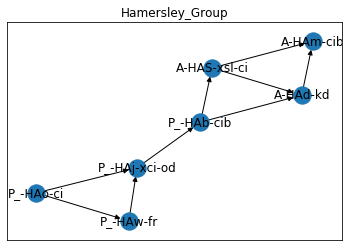

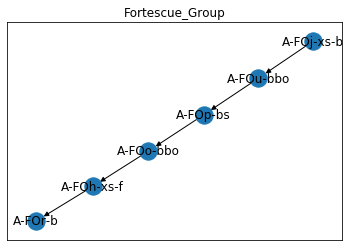

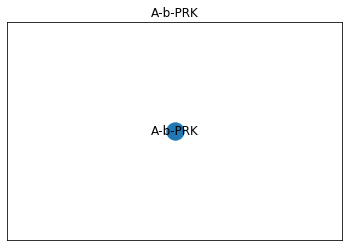

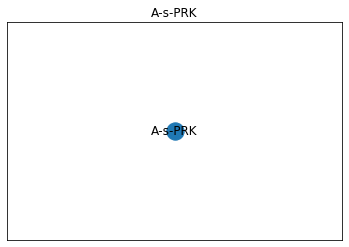

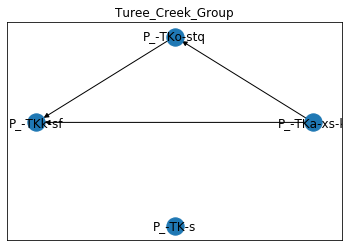

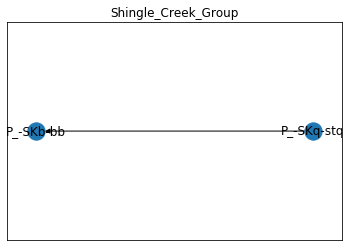

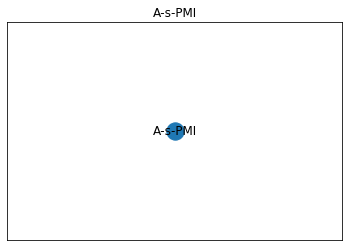

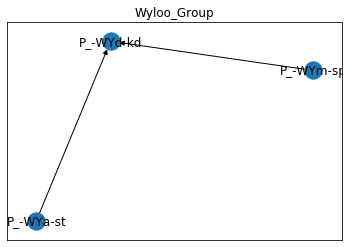

In [7]:
print("groups:",groups)

for p in glabels: #process each group, removing nodes that are not part of that group, and other groups
    GD=G.copy() #temporary copy of full graph
    print()
    print(p,glabels[p],"----------------------")
    nlist=list(G.nodes)
    for n in nlist: # Calculate total number of groups and their names groups
        if('gid' in GD.nodes[n]): #normal node
            if(GD.nodes[n]['gid']!=p): #normal node but not part of current group
                GD.remove_node(n)
        else:                     #group node
            GD.remove_node(n)
    
    labels = {}
    for node in GD.nodes():   #local store of node labels     
        labels[node] = G.nodes[node]['LabelGraphics']['text'].replace(" ","_")
    
    plt.figure(p+1) #display strat graph for one group
    plt.title(glabels[p])
    nx.draw_networkx(GD, pos=nx.kamada_kawai_layout(GD), arrows=True,with_labels=False)
    nx.draw_networkx_labels(GD,pos=nx.kamada_kawai_layout(GD), labels=labels, font_size=12,font_family='sans-serif')
    
    nlist=list(nx.all_topological_sorts(GD)) #all possible sorted directional graphs
    f = open('.\\tmp\\'+glabels[p]+'.txt', 'w')

    print("choices:",len(nlist))
    f.write(str(len(nlist))+" ")
    f.write(str(len(GD))+"\n")
    for m in range(len(nlist)): #process all sorted graphs
        for n in range(0,len(GD)): #display nodes for one sorted graph
            print(nlist[m][n],G.nodes[nlist[m][n]]['LabelGraphics']['text'])
            f.write(G.nodes[nlist[m][n]]['LabelGraphics']['text']+"\n")
        if(m<len(nlist)-1):
            print("....")
    f.close()
           
Gp=nx.Graph().to_directed() #New Group graph
print()

nlist=list(G.nodes)
for n in nlist: # Find out total number of groups and their names groups
    if('isGroup' in G.nodes[n]):
        G.add_nodes_from([n])
        #print(n)

for e in G.edges:
    if(G.nodes[e[0]]['gid']!=G.nodes[e[1]]['gid']):
        #print(G.nodes[e[0]]['gid'],G.nodes[e[1]]['gid'])
        Gp.add_edge(G.nodes[e[0]]['gid'],G.nodes[e[1]]['gid'])

## Create possible stratigraphy sets per group
mj: <font color='red'>Uses first of each possible set of toplogies per unit and per group, which is arbitrary. </font>On the other hand we are not checking relative ages again to see if this helps reduce ambiguity, which I think it would.

/home/lgrose/FME/fme/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/lgrose/FME/fme/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


group choices: 6
[[32, 30, 13, 0, 2, 26, 28, 19], [32, 30, 13, 0, 2, 26, 19, 28], [32, 30, 13, 0, 2, 28, 19, 26], [32, 30, 13, 0, 2, 28, 26, 19], [32, 30, 13, 0, 2, 19, 26, 28], [32, 30, 13, 0, 2, 19, 28, 26]]


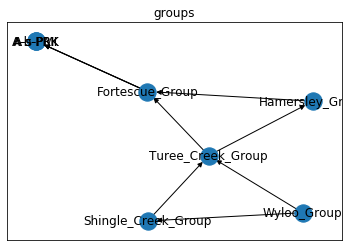

FileNotFoundError: [Errno 2] No such file or directory: './tmp/Wyloo_Group.txt'

In [23]:
GpD=Gp.copy() #temporary copy of full graph
GpD2=Gp.copy() #temporary copy of full graph

for e in GpD2.edges: #remove duplicate edges with opposite directions
    for f in GpD.edges:
        if(e[0]==f[1] and e[1]==f[0] and e[0]<f[0]): #arbitrary choice to ensure edge is not completely removed
            Gp.remove_edge(e[0],e[1])

plt.figure(groups+1) #display strat graph for one group
plt.title("groups")
nx.draw_networkx(Gp, pos=nx.kamada_kawai_layout(Gp), arrows=True,with_labels=False)
nx.draw_networkx_labels(Gp,pos=nx.kamada_kawai_layout(Gp), labels=glabels, font_size=12,font_family='sans-serif')

glist=list(nx.all_topological_sorts(Gp)) #all possible sorted directional graphs    
print("group choices:",len(glist))
print(glist)
nx.write_gml(Gp, './tmp/'+mname+'_groups.gml')
plt.show()

f = open('./tmp/'+mname+'_groups.txt', 'w')
f.write(str(len(glist))+" ")
f.write(str(len(glist[0]))+"\n")

for n in range(0,len(glist)):
    for m in range(0,len(glist[0])):    
        f.write(str(glabels[glist[0][m]])+"\n") #check underscore
f.close()


g=open('./tmp/'+mname+'_groups.txt',"r")
contents =g.readlines()
g.close
hdr=contents[0].split(" ")

ag=open('./tmp/'+mname+'_all_sorts.txt',"w")
for i in range(1,int(hdr[1])+1):
    f=open('./tmp/'+contents[i].replace("\n","")+".txt","r")#check underscore
    ucontents =f.readlines()
    f.close
    uhdr=ucontents[0].split(" ")
    for j in range(1,int(uhdr[1])+1):
        print(ucontents[j].replace("\n",""))
        ag.write(ucontents[j].replace("\n","")+"\n")
ag.close()

## Load geology & structure data
Currently loading from local files, but could load geology from WFS server at GSWA EXCEPT that the WFS online map has less fields that the zipped shapefiles. Go figure. We don't use fault layer at the moment (except for Vitaliy's topology code) but same logic applies in terms of where to get it from. Already have fault/strat relationships and once we have fault/fault relationships will start to include faults in models.

{'init': 'epsg:28350'}


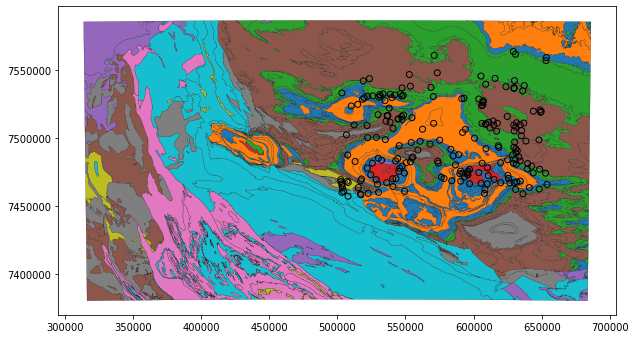

In [24]:
# Extract point data from WAROX & geology map for gempy
##First we readin the WAROX and map from shapefiles, or wherever...

import geopandas as gpd
import os
from shapely.geometry import Polygon
from shapely.geometry import Point


%matplotlib inline
# os.environ["PROJ_LIB"] = r"C:\Users\00073294\AppData\Local\Continuum\anaconda3\Lib\site-packages\pyproj\proj_dir\share\proj"


geology = gpd.read_file('./data/'+mname+'_geol.shp')
print(geology.crs)

#crs = {'init': 'epsg:4326'}


#print(geology.crs)
base=geology.plot(column=ccode,figsize=(10,10),edgecolor='#000000',linewidth=0.2)
#polygon.plot(ax=base, color='none',edgecolor='black')

warox = gpd.read_file('./data/'+mname+'_structure.shp')
warox.crs=dst_crs

sub_pts = warox[['geometry',dcode,ddcode]]

sub_pts.plot(ax=base, color='none',edgecolor='black')

## Useful code for clipping vector data

In [25]:
#https://github.com/earthlab/earthpy/blob/master/earthpy/clip.py
"""
earthpy.clip
============
A module to clip vector data using GeoPandas.
"""

import pandas as pd
import geopandas as gpd


def _clip_points(shp, clip_obj):
    """Clip point geometry to the clip_obj GeoDataFrame extent.
    Clip an input point GeoDataFrame to the polygon extent of the clip_obj
    parameter. Points that intersect the clip_obj geometry are extracted with
    associated attributes and returned.
    Parameters
    ----------
    shp : GeoDataFrame
        Composed of point geometry that is clipped to clip_obj.
    clip_obj : GeoDataFrame
        Reference polygon for clipping.
    Returns
    -------
    GeoDataFrame
        The returned GeoDataFrame is a subset of shp that intersects
        with clip_obj.
    """
    poly = clip_obj.geometry.unary_union
    return shp[shp.geometry.intersects(poly)]


def _clip_multi_point(shp, clip_obj):
    """Clip multi point features to the clip_obj GeoDataFrame extent.
    Clip an input multi point to the polygon extent of the clip_obj
    parameter. Points that intersect the clip_obj geometry are
    extracted with associated attributes returned.
    Parameters
    ----------
    shp : GeoDataFrame
        multipoint geometry that is clipped to clip_obj.
    clip_obj : GeoDataFrame
        Reference polygon for clipping.
    Returns
    -------
    GeoDataFrame
        The returned GeoDataFrame is a clipped subset of shp
        containing multi-point and point features.
    """

    # Explode multi-point features when clipping then recreate geom
    clipped = _clip_points(shp.explode().reset_index(level=[1]), clip_obj)
    clipped = clipped.dissolve(by=[clipped.index]).drop(columns="level_1")[
        shp.columns.tolist()
    ]

    return clipped


def _clip_line_poly(shp, clip_obj):
    """Clip line and polygon geometry to the clip_obj GeoDataFrame extent.
    Clip an input line or polygon to the polygon extent of the clip_obj
    parameter. Lines or Polygons that intersect the clip_obj geometry are
    extracted with associated attributes and returned.
    Parameters
    ----------
    shp : GeoDataFrame
        Line or polygon geometry that is clipped to clip_obj.
    clip_obj : GeoDataFrame
        Reference polygon for clipping.
    Returns
    -------
    GeoDataFrame
        The returned GeoDataFrame is a clipped subset of shp
        that intersects with clip_obj.
    """
    # Create a single polygon object for clipping
    poly = clip_obj.geometry.unary_union
    spatial_index = shp.sindex

    # Create a box for the initial intersection
    bbox = poly.bounds
    # Get a list of id's for each object that overlaps the bounding box and
    # subset the data to just those lines
    sidx = list(spatial_index.intersection(bbox))
    shp_sub = shp.iloc[sidx]

    # Clip the data - with these data
    clipped = shp_sub.copy()
    clipped["geometry"] = shp_sub.intersection(poly)

    # Return the clipped layer with no null geometry values
    return clipped[clipped.geometry.notnull()]


def _clip_multi_poly_line(shp, clip_obj):
    """Clip multi lines and polygons to the clip_obj GeoDataFrame extent.
    Clip an input multi line or polygon to the polygon extent of the clip_obj
    parameter. Lines or Polygons that intersect the clip_obj geometry are
    extracted with associated attributes and returned.
    Parameters
    ----------
    shp : GeoDataFrame
        multiLine or multipolygon geometry that is clipped to clip_obj.
    clip_obj : GeoDataFrame
        Reference polygon for clipping.
    Returns
    -------
    GeoDataFrame
        The returned GeoDataFrame is a clipped subset of shp
        that intersects with clip_obj.
    """

    # Clip multi polygons
    clipped = _clip_line_poly(shp.explode().reset_index(level=[1]), clip_obj)

    lines = clipped[
        (clipped.geometry.type == "MultiLineString")
        | (clipped.geometry.type == "LineString")
    ]
    line_diss = lines.dissolve(by=[lines.index]).drop(columns="level_1")

    polys = clipped[clipped.geometry.type == "Polygon"]
    poly_diss = polys.dissolve(by=[polys.index]).drop(columns="level_1")

    return gpd.GeoDataFrame(
        pd.concat([poly_diss, line_diss], ignore_index=True)
    )


def clip_shp(shp, clip_obj):
    """Clip points, lines, or polygon geometries to the clip_obj extent.
    Both layers must be in the same Coordinate Reference System (CRS) and will
    be clipped to the full extent of the clip object.
    If there are multiple polygons in clip_obj,
    data from shp will be clipped to the total boundary of
    all polygons in clip_obj.
    Parameters
    ----------
    shp : GeoDataFrame
          Vector layer (point, line, polygon) to be clipped to clip_obj.
    clip_obj : GeoDataFrame
          Polygon vector layer used to clip shp.
          The clip_obj's geometry is dissolved into one geometric feature
          and intersected with shp.
    Returns
    -------
    GeoDataFrame
         Vector data (points, lines, polygons) from shp clipped to
         polygon boundary from clip_obj.
    Examples
    --------
    Clipping points (glacier locations in the state of Colorado) with
    a polygon (the boundary of Rocky Mountain National Park):
        >>> import geopandas as gpd
        >>> import earthpy.clip as cl
        >>> from earthpy.io import path_to_example
        >>> rmnp = gpd.read_file(path_to_example('rmnp.shp'))
        >>> glaciers = gpd.read_file(path_to_example('colorado-glaciers.geojson'))
        >>> glaciers.shape
        (134, 2)
        >>> rmnp_glaciers = cl.clip_shp(glaciers, rmnp)
        >>> rmnp_glaciers.shape
        (36, 2)
    Clipping a line (the Continental Divide Trail) with a
    polygon (the boundary of Rocky Mountain National Park):
        >>> cdt = gpd.read_file(path_to_example('continental-div-trail.geojson'))
        >>> rmnp_cdt_section = cl.clip_shp(cdt, rmnp)
        >>> cdt['geometry'].length > rmnp_cdt_section['geometry'].length
        0    True
        dtype: bool
    Clipping a polygon (Colorado counties) with another polygon
    (the boundary of Rocky Mountain National Park):
        >>> counties = gpd.read_file(path_to_example('colorado-counties.geojson'))
        >>> counties.shape
        (64, 13)
        >>> rmnp_counties = cl.clip_shp(counties, rmnp)
        >>> rmnp_counties.shape
        (4, 13)
    """
    try:
        shp.geometry
        clip_obj.geometry
    except AttributeError:
        raise AttributeError(
            "Please make sure that your input and clip GeoDataFrames have a"
            " valid geometry column"
        )

    if not any(shp.intersects(clip_obj.unary_union)):
        raise ValueError("Shape and crop extent do not overlap.")

    if any(shp.geometry.type == "MultiPoint"):
        return _clip_multi_point(shp, clip_obj)
    elif any(shp.geometry.type == "Point"):
        return _clip_points(shp, clip_obj)
    elif any(shp.geometry.type == "MultiPolygon") or any(
        shp.geometry.type == "MultiLineString"
    ):
        return _clip_multi_poly_line(shp, clip_obj)
    else:
        return _clip_line_poly(shp, clip_obj)

## Useful code for exploding MultiPolygons

In [26]:
#https://gist.github.com/mhweber/cf36bb4e09df9deee5eb54dc6be74d26
    
import geopandas as gpd
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon

def explode(indf):
#    indf = gpd.GeoDataFrame.from_file(indata)
    outdf = gpd.GeoDataFrame(columns=indf.columns)
    for idx, row in indf.iterrows():
        if type(row.geometry) == Polygon:
            outdf = outdf.append(row,ignore_index=True)
        if type(row.geometry) == MultiPolygon:
            multdf = gpd.GeoDataFrame(columns=indf.columns)
            recs = len(row.geometry)
            multdf = multdf.append([row]*recs,ignore_index=True)
            for geom in range(recs):
                multdf.loc[geom,'geometry'] = row.geometry[geom]
            outdf = outdf.append(multdf,ignore_index=True)
    return outdf

## Clip map & structure points

In [27]:
left=minx
right=maxx
bottom=miny
top=maxy

print(left,right,bottom,top)


500057 603028 7455348 7567953


In [28]:
bbox=str(bottom)+","+str(left)+","+str(top)+","+str(right)
lat_point_list = [bottom, bottom, top, top, bottom]
lon_point_list = [left, right, right, left, left]
print(bbox)
bbox_geom = Polygon(zip(lon_point_list, lat_point_list))

polyg = gpd.GeoDataFrame(index=[0], crs=dst_crs, geometry=[bbox_geom]) 
print(polyg.geometry.crs)

7455348,500057,7567953,603028
epsg:28350


In [29]:
display(geology.crs)


{'init': 'epsg:28350'}

In [30]:
geology = explode(geology)
geology.crs = dst_crs
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',None)
warox_code = gpd.sjoin(sub_pts, geology, how="left", op="within")




for i in range(0,len(warox_code)):
    if(str(warox_code[i:i+1][ccode].item())=='A-b-PRK'):
        print(str(warox_code[i:i+1][gcode].item()))
    if(str(warox_code[i:i+1][gcode].item())=='None' or str(warox_code[i:i+1][gcode].item())=='TOL' ):
        warox_code.set_value(i, gcode, warox_code[i:i+1][ccode].item())
        print("...",warox_code[i:i+1][gcode].item())
        

display(warox_code)


/home/lgrose/FME/fme/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: `item` has been deprecated and will be removed in a future version
  # This is added back by InteractiveShellApp.init_path()
/home/lgrose/FME/fme/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: `item` has been deprecated and will be removed in a future version
  del sys.path[0]
/home/lgrose/FME/fme/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: `item` has been deprecated and will be removed in a future version
  
/home/lgrose/FME/fme/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
/home/lgrose/FME/fme/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: `item` has been deprecated and will be removed in a future version
  from ipykernel import kernelapp as app
/home/lgrose/FME/fme/lib/python3.6/site-packages/

... P_-WYm-sp
... P_-WYd-kd
None
... A-b-PRK
... A-s-PMI
... A-s-PMI
... A-mgn-PMI
... A-s-PMI
... P_-WYa-st


,geometry,DIP,DIP_DIR,index_right,OBJECTID_1,OBJECTID,LITHSTRTNO,CODE,UNITNAME,GSWASTATUS,RANK,DESCRIPTN,PARENTCODE,PARENTNAME,ROCKTYPE1,LITHNAME1,QUALIFIER1,QUALIFIER2,MIXEDROCK,ROCKTYPE2,LITHNAME2,MIXEDQUAL1,MIXEDQUAL2,WASTRAUNIT,SUPERSUITE,SUITE,SUPERGROUP,GROUP_,SUBGROUP,FORMATION,MEMBER,BED,STATE,WATECTUNIT,SSUITE_TEC,SUITE_TEC,CRATON,SUPERTERRA,CRATON_TER,DOMAIN_,GREENSTONE,SUPERBASIN,BASIN,SUBBASIN,SUBBASIN_E,OROGEN,PROVINCE,PROV_TZONE,TECT_SUBDI,OROG_FOR,OROG_FORSU,IN_OUTLIER,EVENTS,AGEFROM,AGETO,MAX_AGE_MA,MAXUNCERTY,MIN_AGE_MA,MINUNCERTY,MAX_AGE_DA,MIN_AGE_DA,EXTRACT_DA,SHAPE_Leng,ORIG_FID,Shape_Le_1,Shape_Area
0,POINT (530083.1853321539 7485329.520625224),55,8,39,40,33,2069,A-FOh-xs-f,Hardey Formation,Formal,Formation,Sedimentary and felsic volcanic rocks; local i...,A-FO-xb-s,Fortescue Group,sedimentary siliciclastic,None,None,None,Mixed,igneous felsic volcanic,None,None,None,None,None,None,Mount Bruce Supergroup,Fortescue Group,None,Hardey Formation,None,None,Western Australia,West Australian Craton,None,None,None,None,None,None,None,None,Fortescue Basin,Marble Bar Sub-basin; Northeast Pilbara Sub-ba...,None,None,None,None,None,None,None,None,Capricorn Orogeny; Edmundian Orogeny; Ophthalm...,Neoarchean,Neoarchean,2766,7,2749,5,Isotopic,Isotopic,2014-12-04,2.135818,32,2.135818,0.020876
1,POINT (532466.0586118693 7483851.537509387),40,10,39,40,33,2069,A-FOh-xs-f,Hardey Formation,Formal,Formation,Sedimentary and felsic volcanic rocks; local i...,A-FO-xb-s,Fortescue Group,sedimentary siliciclastic,None,None,None,Mixed,igneous felsic volcanic,None,None,None,None,None,None,Mount Bruce Supergroup,Fortescue Group,None,Hardey Formation,None,None,Western Australia,West Australian Craton,None,None,None,None,None,None,None,None,Fortescue Basin,Marble Bar Sub-basin; Northeast Pilbara Sub-ba...,None,None,None,None,None,None,None,None,Capricorn Orogeny; Edmundian Orogeny; Ophthalm...,Neoarchean,Neoarchean,2766,7,2749,5,Isotopic,Isotopic,2014-12-04,2.135818,32,2.135818,0.020876
2,POINT (504669.3230735423 7461016.86484253),70,181,941,942,905,4177,P_-WYm-sp,Mount McGrath Formation,Formal,Formation,"Ferruginous sandstone and conglomerate, quartz...",P_-WY-s,"Wyloo Group, upper",sedimentary siliciclastic,sandstone + conglomerate,None,None,None,None,None,None,None,None,None,None,P_-WYm-sp,Wyloo Group,None,Mount McGrath Formation,None,None,Western Australia,West Australian Craton,None,None,None,None,None,None,None,None,Ashburton Basin,None,None,Capricorn Orogen,None,None,None,Ashburton Fold Belt,None,None,Ashburton Fold Belt D1a/M1a; Ashburton Fold Be...,Paleoproterozoic,Paleoproterozoic,2010,None,1799,None,Inferred,Inferred,2014-12-04,1.083165,904,1.083165,0.006600
3,POINT (503404.3319343358 7460230.336055614),45,182,923,924,887,1413,P_-WYd-kd,Duck Creek Dolomite,Formal,Formation,Thin- to thick-bedded laminated dolostone,P_-WY-s,"Wyloo Group, upper",sedimentary carbonate,dolostone/dolomite,None,None,None,None,None,None,None,None,None,None,P_-WYd-kd,Wyloo Group,None,Duck Creek Dolomite,None,None,Western Australia,West Australian Craton,None,None,None,None,None,None,None,None,Ashburton Basin,None,None,Capricorn Orogen,None,None,None,Ashburton Fold Belt,None,None,Ashburton Fold Belt D1a/M1a; Ashburton Fold Be...,Paleoproterozoic,Paleoproterozoic,2010,None,1799,None,Inferred,Inferred,2014-12-04,5.915156,886,5.915156,0.100818
4,POINT (517319.4798376544 7458551.539931033),10,199,862,863,826,4227,P_-SKq-stq,Beasley River Quartzite,Formal,Formation,"Fine- to coarse-grained, silicified quartz san...",P_-SK-xb-s,Shingle Creek Group,sedimentary siliciclastic,sandstone,quartzose,None,None,None,None,None,None,None,None,None,Mount Bruce Supergroup,Shingle Creek Group,None,Beasley River Quartzite,None,None,Western Australia,West Australian Craton,None,None,None,None,None,None,None,None,Turee Creek Basin,None,None,Capricorn Orogen,None,None,None,Ashburton Fold Belt; Ophthalmia Fold Belt,None,None,Ashburton Fold Belt D1a/M1a; Ashburton Fold Be...,Pale

7455348,500057,7567953,603028


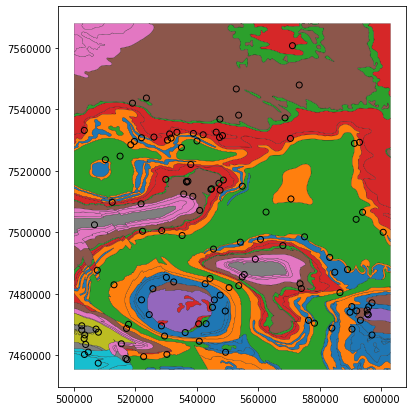

In [32]:
#bbox=str(miny)+","+str(minx)+","+str(maxy)+","+str(maxx)
y_point_list = [miny, miny, maxy, maxy, miny]
x_point_list = [minx, maxx, maxx, minx, minx]
print(bbox)
bbox_geom = Polygon(zip(x_point_list, y_point_list))

polygo = gpd.GeoDataFrame(index=[0], crs=dst_crs, geometry=[bbox_geom]) 

geol_clip=clip_shp(geology, polygo)
#geol_clip=gpd.overlay(geology, polygo, how='intersection')
base = geol_clip.plot(column=ccode,figsize=(7,7),edgecolor='#000000',linewidth=0.2)

warox_clip = clip_shp(warox_code, polygo)
warox_clip.plot(ax=base, color='none',edgecolor='black')
geol_clip.to_file("data/geol_clip.shp")
warox_clip.to_file("data/warox_clip.shp")

## Export orientation data in gempy import format
mj: Orientation data needs calculated height as file does not provide it, taken from SRTM data already downloaded. To calculate polarity <font color='red'>(WHICH WE DON'T DO YET)</font> we can calculate the dot product of the dip direction of a bedding plane and the vector to that points nearest basal contact node, if  abs(acos(dot product))>90  then right way up :

<img src='./graphics/polarity.png'>

In [33]:
from shapely import geometry
import requests
import rasterio

dataset = rasterio.open('./dtm/'+mname+'_dtm_rp.tif')
print(dataset.crs)
print(dataset.width)
print(dataset.height)


EPSG:28350
118
127


In [34]:
i=0
f=open('./gempy/'+mname+'_orientations.txt',"w")
f.write("X,Y,Z,azimuth,dip,polarity,formation\n")
for apoint in warox_code.iterrows():
    if(apoint[1][dcode]==0):
        continue
    elif(orientation_decimate!=0): #decimate to reduce number of points
        if(i%orientation_decimate!=0):
            continue
    locations=[(apoint[1]['geometry'].x, apoint[1]['geometry'].y)]
    #print(locations)
    if(apoint[1]['geometry'].x > minx and apoint[1]['geometry'].x < maxx and  
       apoint[1]['geometry'].y > miny and apoint[1]['geometry'].y < maxy):       
            for val in dataset.sample(locations):
                height=str(val).replace("[","").replace("]","")
            ostr=str(apoint[1]['geometry'].x)+","+str(apoint[1]['geometry'].y)+","+height+","+str(apoint[1][ddcode])+","+str(apoint[1][dcode])+",1,"+str(apoint[1][ccode])+"\n"
            f.write(ostr)
            i+=1
    
f.close()

## needs polarity test

In [35]:
from shapely.geometry import Polygon, mapping
from shapely.geometry import Polygon, Point, LinearRing
import math # or numpy
from math import sin,cos
from shapely.ops import nearest_points

def euclidean_distance( l1,l2):
    return math.sqrt((l2[0]-l1[0])**2 + (l2[1]-l1[1])**2)
contact_decimatex=15

geol_clipx=explode(geol_clip)
d2r=3.1415927/180.0

geol_clipx=explode(geol_clip)
i=0
for apwrx in warox_code.iterrows():
    wpoint = Point(apwrx[1]['geometry'].x,apwrx[1]['geometry'].y)    
    for ageol in geol_clipx.iterrows(): # a polygon
        apoly=Polygon(ageol[1]['geometry'])
        if(not ageol[1]['OBJECTID_1']==41):
            continue
        if(i%contact_decimatex==0):
            close= nearest_points(apoly,wpoint)
            print(apwrx[1]['DIP_DIR'],apwrx[1]['DIP'],"closest point is",close[0].coords[0][0],close[0].coords[0][1],wpoint)
            l=sin(d2r*float(apwrx[1]['DIP_DIR']))*cos(d2r*(90.0-float(apwrx[1]['DIP'])))
            m=cos(d2r*float(apwrx[1]['DIP_DIR']))*cos(d2r*(90.0-float(apwrx[1]['DIP'])))
            n=-sin(d2r*(90.0-float(apwrx[1]['DIP'])))   
            print(i,l,m,n)
    i+=1
    break
            


8 55 closest point is 530767.1470685545 7486815.107889112 POINT (530083.1853321539 7485329.520625224)
0 0.11400393111430744 0.8111801075429168 -0.5735764437432436


## Find those series that don't have any orientation or contact point data 

In [36]:
f=open('./tmp/'+mname+'_groups.txt',"r")
contents =f.readlines()
f.close

ngroups=contents[0].split(" ")
ngroups=int(ngroups[1])

groups=[]
for i in range (1,int(ngroups)+1):
    #print(contents[i].replace("\n",""))
    groups.append((contents[i].replace("\n",""),0))

print(ngroups,groups)

for i in range (0,ngroups):
    for apoint in warox_code.iterrows():
        agroup=apoint[1][gcode]
        #print(agroup)
        if(groups[i][0]==agroup.replace(" ","_")):
            lgroups=list(groups[i])
            lgroups[1]=1
            lgroups=tuple(lgroups)
            groups[i]=lgroups

print("Orientations----------\n",ngroups,groups)

for i in range (0,ngroups):
    for apoly in geology.iterrows():
        agroup=apoint[1][gcode]
        #print(agroup)
        if(groups[i][0]==agroup.replace(" ","_")):
            lgroups=list(groups[i])
            lgroups[1]=1
            lgroups=tuple(lgroups)
            groups[i]=lgroups

all_codes=[]
for ageol in geol_clip.iterrows(): # central polygon
        all_codes.append(ageol[1][ccode])

print("Contacts----------\n",len(set(all_codes)),set(all_codes))


    

8 [('Wyloo_Group', 0), ('Shingle_Creek_Group', 0), ('Turee_Creek_Group', 0), ('Hamersley_Group', 0), ('Fortescue_Group', 0), ('A-s-PMI', 0), ('A-s-PRK', 0), ('A-b-PRK', 0)]
Orientations----------
 8 [('Wyloo_Group', 0), ('Shingle_Creek_Group', 0), ('Turee_Creek_Group', 0), ('Hamersley_Group', 0), ('Fortescue_Group', 0), ('A-s-PMI', 1), ('A-s-PRK', 0), ('A-b-PRK', 1)]
Contacts----------
 29 {'A-HAS-xsl-ci', 'A-s-PRK', 'A-FOu-bbo', 'A-mgn-PRK', 'A-b-PRK', 'A-FO-od', 'P_-WYd-kd', 'P_-TK-s', 'P_-WYa-st', 'P_-SKb-bb', 'A-FO-xo-a', 'P_-HAo-ci', 'A-FOp-bs', 'A-FOh-xs-f', 'A-FOo-bbo', 'P_-HAj-xci-od', 'P_-TKa-xs-k', 'A-FOr-b', 'A-HAd-kd', 'A-mgn-PMI', 'P_-WYm-sp', 'P_-HAb-cib', 'P_-HAw-fr', 'A-HAm-cib', 'P_-SKq-stq', 'P_-TKk-sf', 'A-FOj-xs-b', 'A-s-PMI', 'P_-TKo-stq'}


## Create arbitrary point for series with no orientation data
Not sure if gempy needs this but geomodeller does. <font color='red'>Currently just gives a point dipping 45 degrees to North, but could use dip direction normal to basal surface)</font>

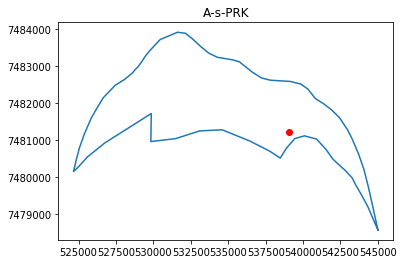

In [37]:
from shapely.geometry import shape, Polygon
import matplotlib.pyplot as plt
f=open('.\\gempy\\'+mname+'_orientations.txt',"a")

for i in range (0,ngroups):
    if(groups[i][1]==0):
        for ageol in geol_clip.iterrows():
            if(ageol[1][ccode]==groups[i][0] and groups[i][1]==0):
                apoly=Polygon(ageol[1]['geometry'])
                apoint=apoly.representative_point()
                #print(apoint.x,apoint.y)
                locations=[(apoint.x,apoint.y)]
                for val in dataset.sample(locations):
                    height=str(val).replace("[","").replace("]","")
                ostr=str(apoint.x)+","+str(apoint.y)+","+height+",0,45,1"+","+str(ageol[1][ccode])+"\n"
                f.write(ostr)
                plt.title(str(ageol[1][ccode]))
                plt.scatter(apoint.x,apoint.y,color="red")
                plt.plot(*apoly.exterior.xy)
                plt.show()
                break

f.close()

## Export contact information subset of each polygon to gempy format
mj: Orientation data needs calculated height as file does not provide it, taken from SRTM data already downloaded. Need to reduce number of points whilst retaining useful info (Ranee's job!)'
To calculate which are the basal units contact for a polygon find the polygons which are older than the selected polygon, in the example below the central polygon has relative age 23 so its basal contact is with the polygons whose ages are 26 & 28. If there are no older units for a polygon it has no basal content. We keep every nth node based on the decimate term (simple count along polyline). gempy seems to need at least two points per surface, so we always take the first two points.

<font color='red'>Needs also to account for case when missing surface in stratigraphy means that locally basal polyline can ALSO be anothe rthan youngest surface.</font>
<img src='./graphics/base.png'>

In [39]:
import rasterio
from shapely.ops import snap
#newwd="C:\\Users\\00073294\Dropbox\\1_Jupyter_notebooks\\map2model\\"
#os.chdir(newwd)

## Reproject topography to approriate metre-based CRS
           
dataset = rasterio.open('./dtm/'+mname+'_dtm_rp.tif')
ag=open('./tmp/'+mname+'_all_sorts.txt',"r")
contents =ag.readlines()
ag.close
print("surfaces:",len(contents))
print("polygons:",len(geol_clip))
ulist=[]
for i in range(0,len(contents)):
    ulist.append([i, contents[i].replace("\n","")])
print(ulist)


ac=open('./gempy/'+mname+'_contacts.txt',"w")
ac.write("X,Y,Z,formation\n")
print(dataset.bounds)
j=0
allpts=0
for ageol in geol_clip.iterrows(): # central polygon
    neighbours=[]
    #print(ageol[1].geometry)
    j+=1
    out=[item for item in ulist if ageol[1][ccode] in item]
    if(len(out)>0):
        central=out[0][0]    #relative age of central polygon
        central_poly=ageol[1].geometry
        for bgeol in geol_clip.iterrows(): #potential neighbouring polygons  
            if(ageol[1].geometry!=bgeol[1].geometry): #do not compare with self
                if (ageol[1].geometry.intersects(bgeol[1].geometry)): # is a neighbour
                    neighbours.append([(bgeol[1][ccode],bgeol[1].geometry)])  

        if(len(neighbours) >0):
            for i in range (0,len(neighbours)):
                out=[item for item in ulist if neighbours[i][0][0] in item]
                #print(out)
                if(len(out)>0):
                    #if(out[0][0] > central and out[0][0] < youngest_older): # neighbour is older than central, and younger than previous candidate
                    if(out[0][0] > central ): # neighbour is older than central
                        older_polygon=neighbours[i][0][1]
                        if(not central_poly.is_valid ):
                            central_poly = central_poly.buffer(0)
                        if(not older_polygon.is_valid):
                            older_polygon = older_polygon.buffer(0)
                        LineStringC = central_poly.intersection(older_polygon)
                        if(LineStringC.wkt.split(" ")[0]=='GEOMETRYCOLLECTION' or 
                           LineStringC.wkt.split(" ")[0]=='MULTIPOLYGON' or
                           LineStringC.wkt.split(" ")[0]=='POLYGON'): #ignore polygon intersections for now, worry about them later!
                             continue                      
                        elif(LineStringC.wkt.split(" ")[0]=='GEOMETRYCOLLECTION' or LineStringC.wkt.split(" ")[0]=='MULTILINESTRING'):
                            i=0
                            for lineC in LineStringC: #process all linestrings
                                if(contact_decimate!=0): #decimate to reduce number of points
                                    if(i%contact_decimate==0 or i==1 or i==2): #decimate to reduce number of points, but also take second and third point of a series to keep gempy happy
                                        locations=[(lineC.coords[0][0],lineC.coords[0][1])] #doesn't like point right on edge?
                                        #print(i,"ml",locations,lineC.coords[0][1], maxy)
                                        if(lineC.coords[0][0] > dataset.bounds[0] and lineC.coords[0][0] < dataset.bounds[2] and  
                                           lineC.coords[0][1] > dataset.bounds[1] and lineC.coords[0][1] < dataset.bounds[3]):       
                                                for val in dataset.sample(locations):
                                                    height=str(val).replace("[","").replace("]","")
                                                ostr=str(lineC.coords[0][0])+","+str(lineC.coords[0][1])+","+height+","+str(ageol[1][ccode])+"\n"
                                                ac.write(ostr)
                                                allpts+=1
                                else:
                                    locations=[(lineC.coords[0][0]+0.0000001,lineC.coords[0][1])] #doesn't like point right on edge?
                                    if(lineC.coords[0][0] > dataset.bounds[0] and lineC.coords[0][0] < dataset.bounds[2] and  
                                        lineC.coords[0][1] > dataset.bounds[1] and lineC.coords[0][1] < dataset.bounds[3]):       
                                        for val in dataset.sample(locations):
                                            height=str(val).replace("[","").replace("]","")
                                        ostr=str(lineC.coords[0][0])+","+str(lineC.coords[0][1])+","+height+","+str(ageol[1][ccode])+"\n"
                                        ac.write(ostr)
                                        allpts+=1

                                i+=1
                        elif(LineStringC.wkt.split(" ")[0]=='LINESTRING'): # apparently this is not needed
                            i=0
                            for pt in LineStringC.coords: #process one linestring
                                #if(i%contact_decimate==0): #decimate to reduce number of points
                                #print("ls",pt)
                                """
                                locations=[(float(pt[0]),float(pt[1]))]
                                for val in dataset.sample(locations):
                                    height=str(val).replace("[","").replace("]","")
                                ostr=str(pt[0])+","+str(pt[1])+","+height+","+str(ageol[1][ccode])+"\n"
                                ac.write(ostr)
                                """
                                i+=1
                        elif(LineStringC.wkt.split(" ")[0]=='POINT'): # apparently this is not needed
                            #print("pt",LineStringC.coords)
                            """
                            locations=[(float(pt[0]),float(pt[1]))]
                            for val in dataset.sample(locations):
                                height=str(val).replace("[","").replace("]","")
                            ostr=str(pt[0])+","+str(pt[1])+","+height+","+str(ageol[1][ccode])+"\n"
                            ac.write(ostr)
                            """
                            i+=1
                        else:
                            #print(LineStringC.wkt.split(" ")[0]) # apparently this is not needed
                            i+=1



ac.close()
print("allpts=",allpts)



surfaces: 0
polygons: 186
[]
BoundingBox(left=500000.0000000026, bottom=7454093.693147668, right=605065.852135498, top=7567173.042479938)
allpts= 0


## Now we define the basic model and load the orientation and lithological information
mj: We inset the model dimensions as once reprojects the edge pixels of the topography are undefined. Probably doesn't need to be that extreme (unit is metres). Uses parameter <b>maxtopo</b> from maximum elevtion to define upper bound to Z. 

In [41]:
f=open('./gempy/'+mname+'_contacts.txt',"r")
contents =f.readlines()
f.close

all_cpts=[]
for cpt in contents[1:]:
    cpt2=cpt.split(",")[3]
    all_cpts.append(cpt2.replace("\n",""))
actual_cpts=set(all_cpts)
print(actual_cpts)

f=open('./gempy/'+mname+'_contacts2.txt',"w")
f.write(contents[0])
for cpt in contents[1:]:
    cpt2=cpt.split(",")[3]
    cpt2=cpt2.replace("\n","")
    out=[item for item in actual_cpts if cpt2 in item]
    if(len(out)>0):
        f.write(cpt)
    else:
        print(cpt)
f.close()

f=open('./gempy/'+mname+'_orientations.txt',"r")
ocontents =f.readlines()
f.close

f=open('./gempy/'+mname+'_orientations2.txt',"w")
f.write(ocontents[0])
for cpt in ocontents[1:]:
    cpt2=cpt.split(",")[6]
    cpt2=cpt2.replace("\n","")
    out=[item for item in actual_cpts if cpt2 in item]
    if(len(out)>0):
        f.write(cpt)
    else:
        print(cpt)
f.close()





set()
530083.1853321539,7485329.520625224,415,8,55,1,A-FOh-xs-f

532466.0586118693,7483851.537509387,419,10,40,1,A-FOh-xs-f

504669.3230735423,7461016.86484253,299,181,70,1,P_-WYm-sp

503404.33193433576,7460230.336055614,298,182,45,1,P_-WYd-kd

517319.47983765445,7458551.539931033,338,199,10,1,P_-SKq-stq

516865.3849028363,7458957.04590488,333,227,45,1,P_-TK-s

515438.1815205008,7463725.081268248,353,359,44,1,P_-HAj-xci-od

507945.2849673012,7467495.909622293,437,203,58,1,P_-TKk-sf

503517.6591896642,7466603.797579262,410,0,60,1,P_-TKk-sf

503809.7052735864,7463489.819689126,296,3,68,1,P_-SKq-stq

502536.4299599883,7468201.274627255,460,213,16,1,P_-SKq-stq

502536.41908570274,7469579.769568286,361,186,12,1,P_-SKq-stq

503306.7931686398,7465431.798659263,311,360,82,1,P_-TKk-sf

507187.87694126955,7468501.372442812,332,216,10,1,P_-SKq-stq

517107.03367644735,7468722.02834858,371,207,70,1,A-FOj-xs-b

517762.2141241012,7470058.525651742,374,207,51,1,A-FOu-bbo

522004.8079015461,7478030.914

In [44]:
import pandas as pd
print(os.getcwd())

/mnt/c/Users/lgrose/Documents/Repositories/map2model/hams2


In [48]:
orientations = pd.read_csv("gempy/hams2_orientations.txt")
contacts = pd.read_csv("gempy/hams2_contacts.txt")